# Analysing individual Recommenders

In [1]:
import config
from src.utils.MetricsEvaluator import MetricsEvaluator
from src.utils.RecommendationUtils import RecommendationUtils
from config import experiment_years
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools

data_stem = "../../scala-code/data/processed/"
rec_utils = RecommendationUtils(data_stem, 'RS')

yr = 2012

## Analysis constants and setup

In [2]:
CONST_min, CONST_max, CONST_stepsize = 5, 51, 5

k_list = range(CONST_min, CONST_max, CONST_stepsize)
params = list(itertools.product(k_list, [yr]))

In [4]:
metrics_evaluators = {}
models = ["CF-user_rec", "CF-user_artist", "Tailored"]
for (k_, yr_) in params:
#     metrics_evaluators[(yr_, k_)] = MetricsEvaluator(models=models, year=yr_, k=k_, archive_size=100)
    metrics_evaluators[(yr_, k_)] = MetricsEvaluator(models=models, year=yr_, k=k_)

Initializing MetricsEvaluator for year:2012 and k:5
Completed initialization
Initializing MetricsEvaluator for year:2012 and k:10
Completed initialization
Initializing MetricsEvaluator for year:2012 and k:15
Completed initialization
Initializing MetricsEvaluator for year:2012 and k:20
Completed initialization
Initializing MetricsEvaluator for year:2012 and k:25
Completed initialization
Initializing MetricsEvaluator for year:2012 and k:30
Completed initialization
Initializing MetricsEvaluator for year:2012 and k:35
Completed initialization
Initializing MetricsEvaluator for year:2012 and k:40
Completed initialization
Initializing MetricsEvaluator for year:2012 and k:45
Completed initialization
Initializing MetricsEvaluator for year:2012 and k:50
Completed initialization


In [5]:
# metrics_evaluators[(yr_, 50)] = MetricsEvaluator(models=models, year=yr_, k=50)

In [6]:
metrics_evaluators

{(2012, 5): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f3a4c73b2b0>,
 (2012, 10): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f3a4c73b550>,
 (2012, 15): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f390ecda070>,
 (2012, 20): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f390e1e5fa0>,
 (2012, 25): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f38fc71e8b0>,
 (2012, 30): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f38efdb68e0>,
 (2012, 35): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f38e75303a0>,
 (2012, 40): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f38dec440a0>,
 (2012, 45): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f38b3690940>,
 (2012, 50): <src.utils.MetricsEvaluator.MetricsEvaluator at 0x7f38ae20e8b0>}

In [19]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

metrics_to_plot = ['MAR', 'modPers', 'Nov', 'Cov']
metric_marker = {
    'MAR':'*',
    'modPers':'v',
    'Nov':'^',
    'Cov':'p',
}
pretty_names = {
    'MAR': 'Mean Average Recall',
    'MAR_filtered': 'Mean Average Recall (filtered)',
    'NaN_Prop': 'Proportion Unsuccessful Recommendation',
    'Pers': 'Personalization',
    'modPers': 'modified Personalization',
    'Nov': 'Novelty',
    'Cov': 'Coverage',
    'Fam': 'Familiarity',

    "CF-user_rec": "User-Record based Collaborative Filtering",
    "CF-user_artist": "User-Artist based Collaborative Filtering",
    "Pop": "Popular Recommender"
}

## functions: getting metrics for different list sizes

In [20]:
def parallel_evaluation(params_):
    k_, set_, model_, year_ = params_
    metric_eval = metrics_evaluators[(year_, k_)]
    recs_df = metric_eval.recommendation_dfs[(model_, set_)]
    recs_ = RecommendationUtils.get_recommendations_dict_from_single_df(df=recs_df)
    m = metric_eval.get_metrics(metrics_to_plot, recs_, set_, k_)
    metrics_arr = []
    for metric_name in list(m.keys()):
        metrics_arr.append((k_, set_, metric_name, m[metric_name]))
    print(f"Completed: {params_}")
    return metrics_arr

def get_df_per_k_set(model: str, processes:int = config.num_cpu):
    k_list = range(CONST_min, CONST_max, CONST_stepsize)
    params_this_set = list(itertools.product(k_list, range(1,4), [model], [yr]))
    temp_data = Pool(processes).map(parallel_evaluation, params_this_set)
    data = []
    [data.append(y) for x in temp_data for y in x]
    df_ = pd.DataFrame(data, columns=['k', 'set', 'metric', 'val']).reset_index()
    df_ = df_[['k', 'metric', 'val']]\
        .groupby(['k', 'metric'])\
        .agg(['mean', 'std'])
    return df_.reset_index()

## Plotting function

In [146]:
from matplotlib.ticker import StrMethodFormatter

def plot_errorbars_single_recommender(data: pd.DataFrame, model: str, figsize:tuple=(12,5), yscale:str='linear'):
    fig = plt.figure(figsize=figsize, dpi=200)
#     fig.suptitle(f"{pretty_names[model]}\nmetrics errorbars at different list sizes")
    for metric in metrics_to_plot:
        df__ = data[data["metric"] == metric].reset_index()
        plt.errorbar(x=df__['k'],
                     y=df__['val']['mean'],
#                      yerr=df__['val']['std'],
                     fmt='o-', elinewidth=0.5, markersize=5, linewidth=1, alpha=0.7,
                     marker=metric_marker[metric],
                     label=pretty_names[metric])
#     plt.hlines(y=[0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9], xmin=5, xmax=50, color='r', alpha = 0.1)
#     plt.hlines(y=[0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9], xmin=5, xmax=50, color='r', alpha = 0.1)
        
    plt.yscale(yscale)

    plt.xlabel('Recommendation list size $k$')
    plt.ylabel("metric value (\\textbf{%s} scale)"% yscale)
    plt.ylim((-0.1,1.1))
    plt.yticks(np.arange(0.1,1.0, 0.1).tolist()+[0.05,0.95])
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
    
    plt.grid(True, which='both', linewidth=0.5, alpha=0.4)
    plt.legend(fontsize=10)
#     plt.savefig(f'../images/single-recommenders/{model}_{yscale}.svg')

## User-Recording Collaborative Filtering

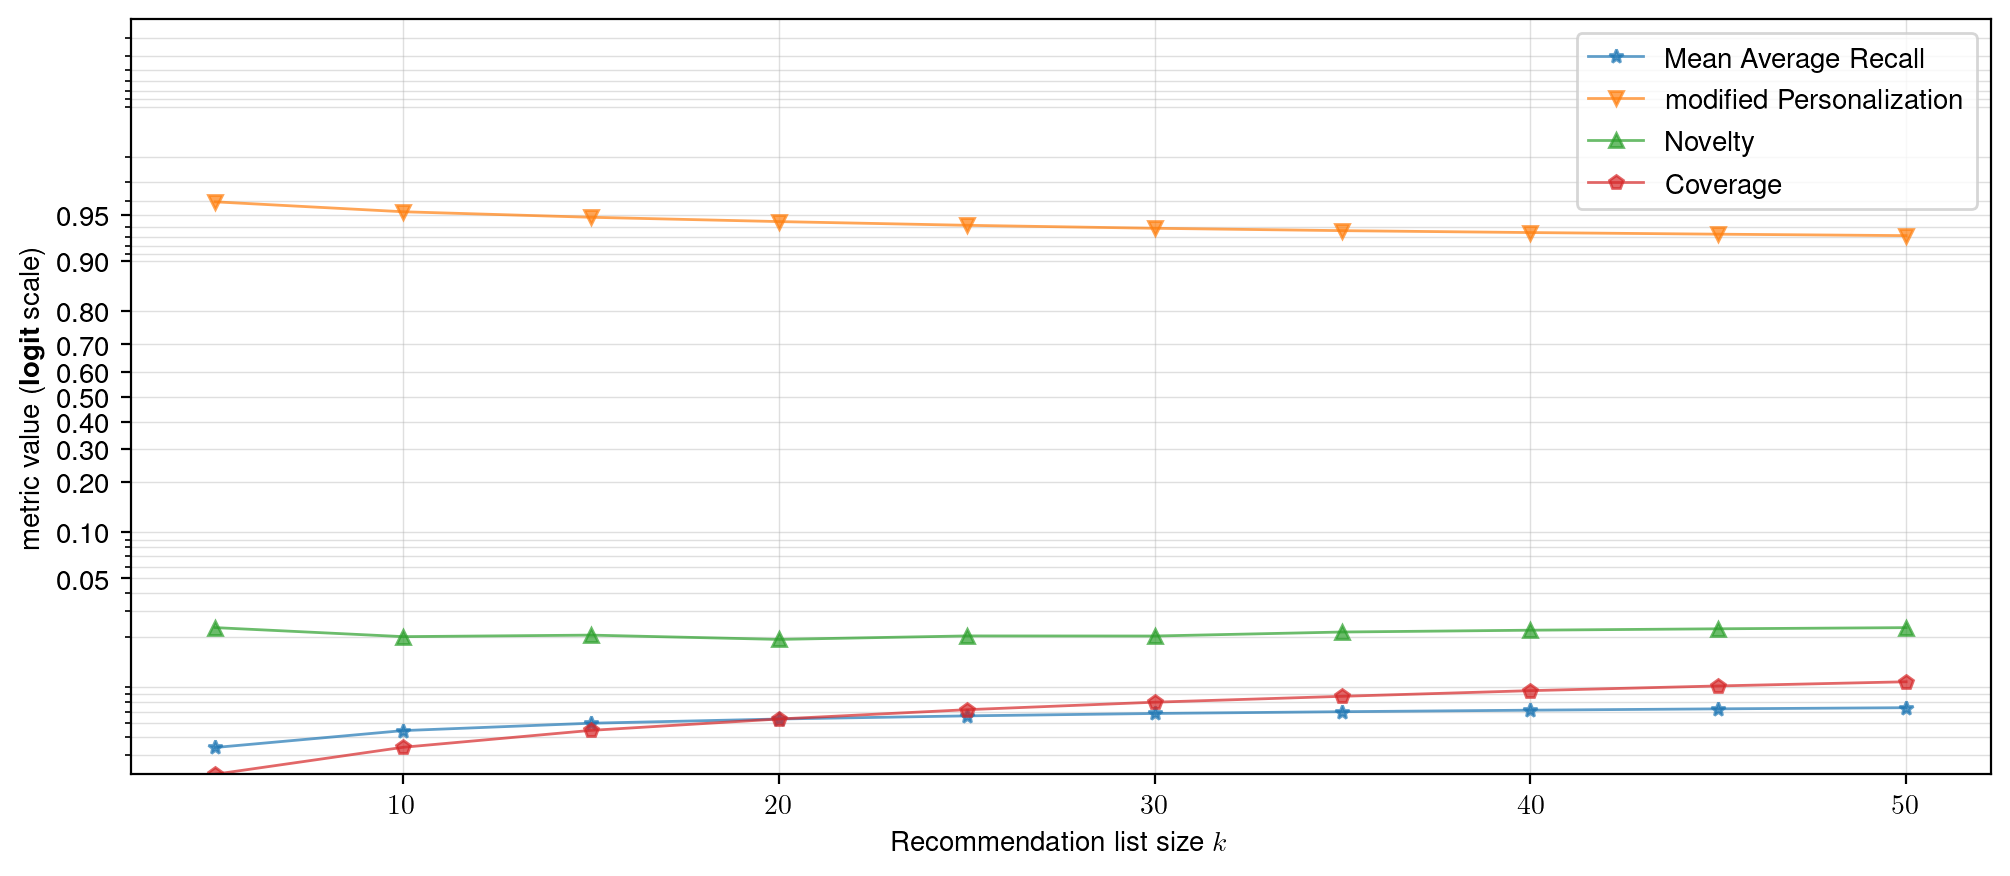

In [147]:
model_ = "CF-user_rec"
# df_1 = get_df_per_k_set(model_)
plot_errorbars_single_recommender(df_1, model=model_, yscale='logit')

## User-Artist Collaborative Filtering

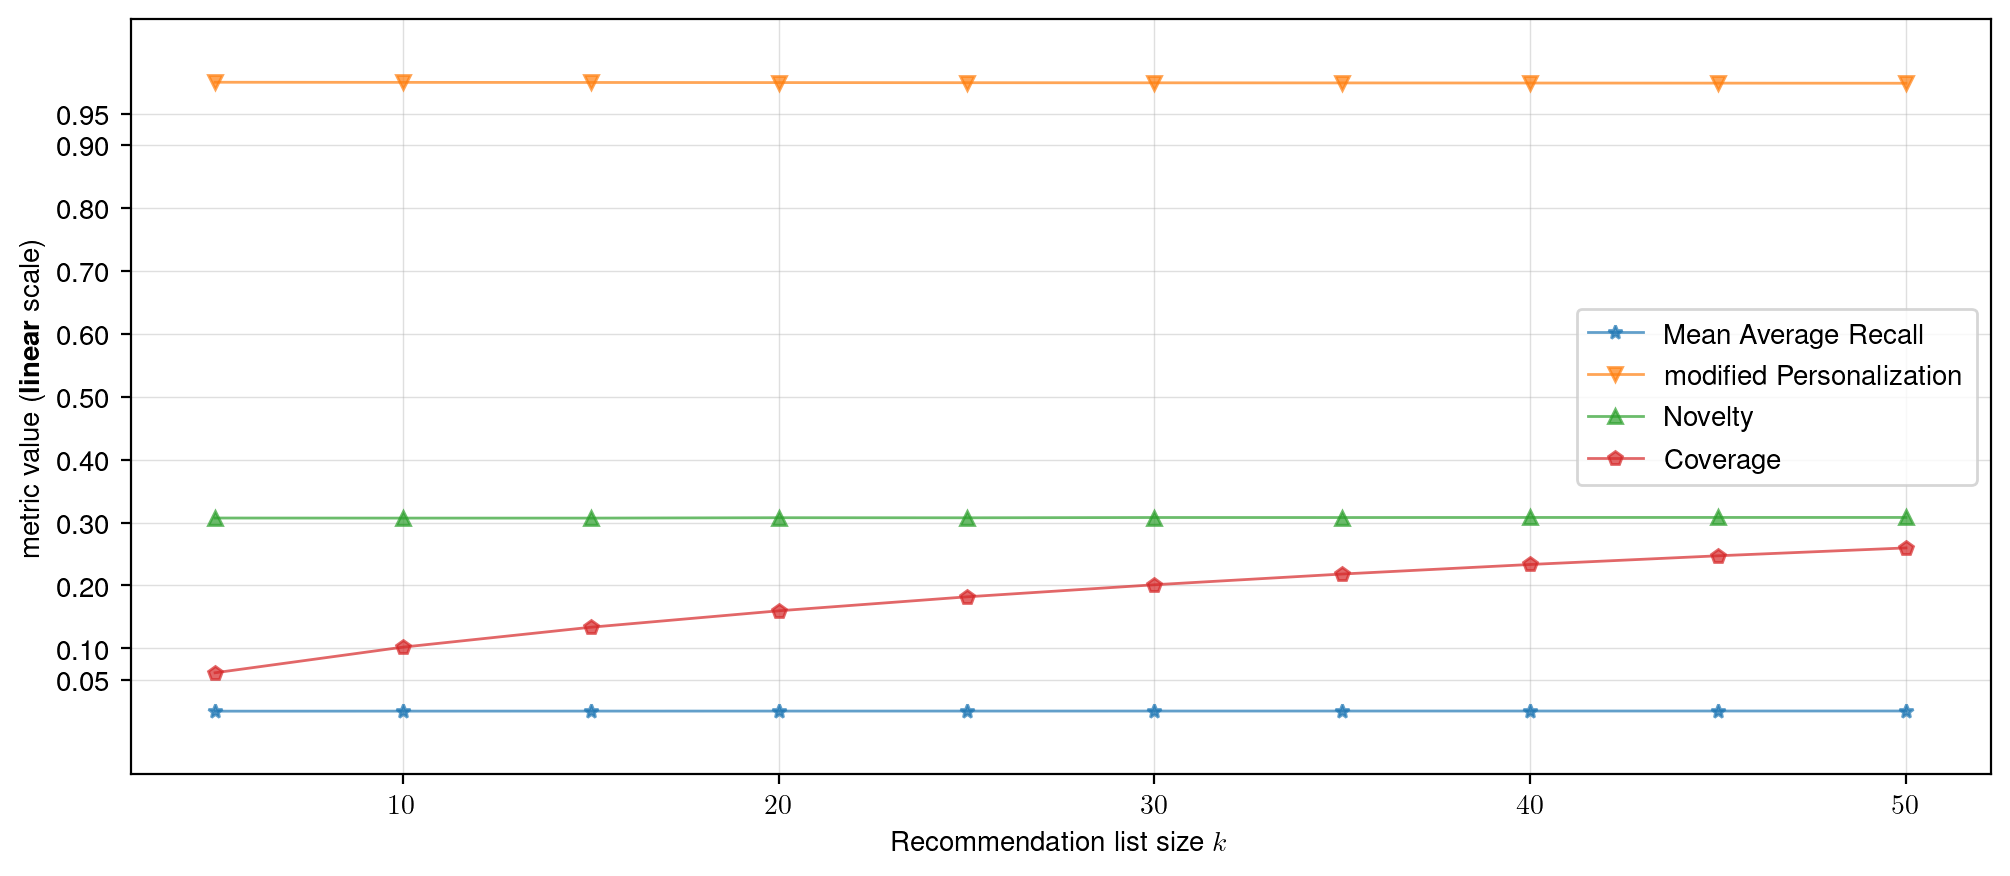

In [154]:
model_ = "CF-user_artist"
# df_2 = get_df_per_k_set(model_, processes = 12)
plot_errorbars_single_recommender(df_2, model=model_, yscale='linear')

## Tailored Recommender

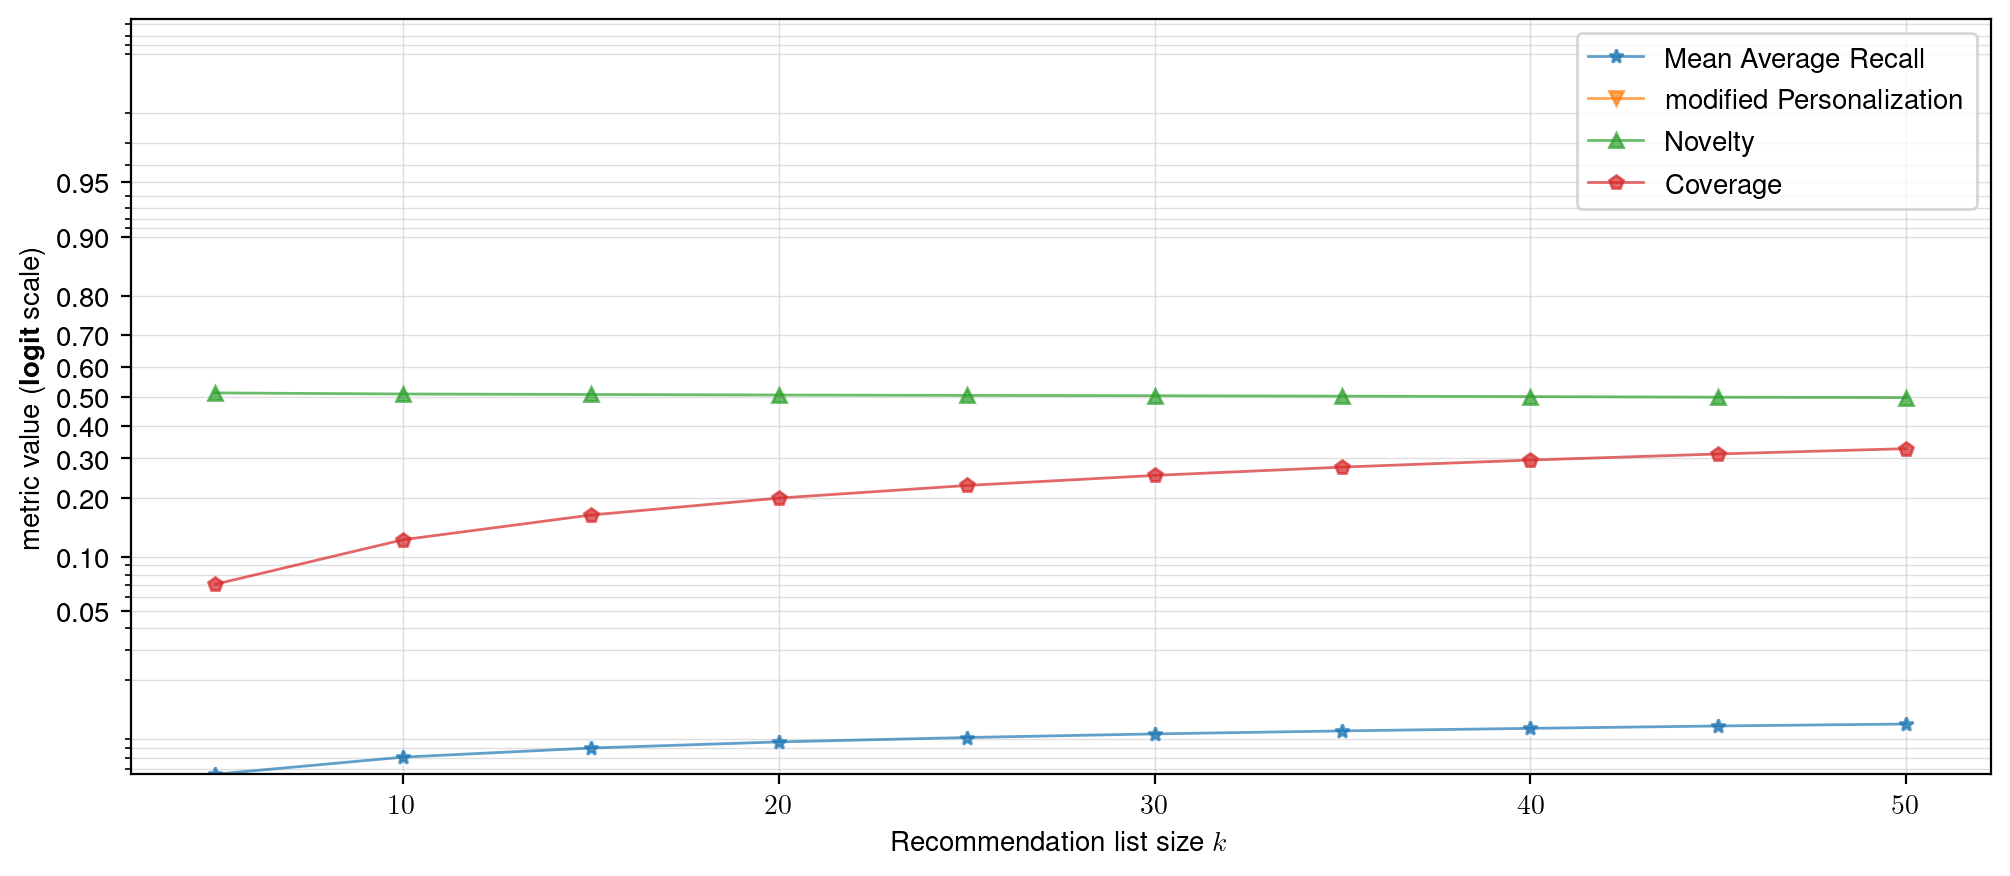

In [155]:
model_ = "Tailored"
# df_3 = get_df_per_k_set(model_, processes = 12)
plot_errorbars_single_recommender(df_3, model=model_, yscale='logit')

In [150]:
# print(df_3)